# Naive Bayes: Whatsapp message classification

Using Whatsapp conversation history, we aim at predicting which user has submitted a given message. For it, we will use Bayes theorem under some coarse assumptions. From Bayes theorem, we can write the conditional probability of a message having been sent by a given member of a group as:

$$ p(\text{user} | \text{message} ) = \frac{ p(\text{message} | \text{user} ) \cdot p(\text{user})}{p(\text{message})} $$

First, in contrast to the typical examples of sick vs. healthy, here there is no counterpart to $message$. In other words $p(\text{message}) = 1$, such that the denominator is constant. The term $p(\text{user})$ indicates the probability of a randomly selected message to be of the given user. Thus, this is simply given by:

$$ p( \text{user} ) = \frac{ \text{\# messages by user}}{\text{\# total messages}} $$

Our next goal is to calculate the conditional probability $p(\text{message} | \text{user} )$. We can do a coarse assumption an say that the probability of a given message is given by the probabilty of every word, where every word in independent of any previous words. Under this independence framwework: 

$$ p(\text{message} | \text{user} ) =  \prod_{i=1}^N p( \text{word}_i | \text{user}) $$

where $N$ is the length of the message. The chances of finding a word for a given user is:

$$ p(\text{word}_i | \text{user} ) =  \frac{\text{\# occurencies word}_i}{\text{\# words by user}} $$


In [256]:
import numpy as np
#from nltk.corpus import stopwords
#from nltk import word_tokenize
import string

from datetime import date

In [257]:
def load_conversations(path_file):
    """
        Loads the conversation and parses the text for straighforward later manipulation
        Warning: Changes of icons or group names leads to errors in the later extraction of 
                the group members

        Parameters:
            - path_file (string): Path to the conversation file
        
        Returns:
           - messages (array): Array of arrays containing all the words for each message 
           - members_msg (array): User assocaited to each of the messages in messages 
           - members (array): Array with the unique users of the conversation
    """
    messages = [] 
    members_msg = []

    members = []
    members_count = 0

    def is_date(date_str):
        data = date_str.split("/") # Separator character for the date
        if len(data) == 3:
            return 1
        else:
            return 0
    
    # TODO: Update
    def remove_punctuation(input_string):
        # Make a translation table that maps all punctuation characters to None
        translator = str.maketrans("", "", string.punctuation)

        # Apply the translation table to the input string
        result = input_string.translate(translator)

        return result

    with open(path_file) as fp:
       
        for cnt, line in enumerate(fp):
            
            str_line = ''.join(line)
            str_line = str_line.lower()
            str_word_list = str_line.split()
        
            if str_word_list: # Check that it doesnt correspond to an empty message
                if is_date(str_word_list[0]) == 1:
                    
                    # If the line is a citation skip the analyis
                    if (str_word_list[0])[0] == "[":
                        continue

                    messages.append(str_word_list[4:])

                    tmp_member = str_word_list[3][:-1]  # The -1 is to remove : from the user
            
                    #if str_word_list[3][-1] == ":":   # We confirm that the last item are : to avoid icon changes

                    members_msg.append(tmp_member)

                    if tmp_member not in members:
                        members.append(tmp_member)
                        members_count += 1


    return messages, members_msg, members



In [258]:
def make_dictionary(messages, members_msg, members):
    """
        Creates a dictionary for every word in the text.
        The dictinary is composed of a dictionary of dictionaries containign the
        word and the number of times each user has employed the word.  For instance,
        
        word_dict = {
                        'hello': {
                            'alice': 1,
                            'bob': 5,
                            'charlie': 3
                    }


        Parameters:
            - messages (array): Array of arrays containing all the words for each message 
            - members_msg (array): User assocaited to each of the messages in messages 
            - members (array): Array with the unique users of the conversation
        Returns: 
            - word_dict (dictinary of dictionaries):  See description above

    """
    # Creates an empty dictionary
    word_dict = {}

    for idm, message in enumerate(messages):
        mmbr = members_msg[idm]
        for word in message:
            
            # Add word if not in the dictionary
            if word not in word_dict.keys():
                word_dict[word] = {m: 1 for m in members}

            word_dict[word][mmbr] += 1

    return word_dict


In [259]:
def split_data(X, Y, fraction):
    """
        Splits the data in training and cross-validations sets
        Parameters:
            - X (string arrays) : Messages, composed of array of strings
            - Y (array of string) : Classes for each user
            - fraction (float) : Proportion of the data to be uset for training
        
        Returns:
           - X_train :
           - X_xval : 
           - Y_train :
           - Y_xval :               
    """     

    n_messages = len(X)
    num_ones = int(np.round(n_messages*fraction))
    
    ids = np.int32(np.random.choice(n_messages, num_ones, replace=False))

    ids_bool_train = np.zeros(n_messages, dtype=bool)
    ids_bool_xval =  np.zeros(n_messages, dtype=bool)
    ids_bool_train[ids] = True
    ids_bool_xval[~ids_bool_train] = True
    
    # We do it in that way (instead of X[ids]) because of having an array of strings X[messsage][words], 
    # which does not allow for the indicated approach 
    X_train = [X[i] for i in ids]
    X_xval = [X[i] for i in  range(0,n_messages) if ids_bool_xval[i]==True]
   
    Y_train = [Y[i] for i in ids]
    Y_xval = [Y[i] for i in  range(0,n_messages) if ids_bool_xval[i]==True]
    

    return X_train, X_xval, Y_train, Y_xval

In [260]:

def messages_by_member(members_msg, member):
    """
        Rerturns the total number of messages of a member in the conversation
    """
    return sum(np.array(members_msg)==member)


def prob_message_by_members(messages, members_msg, members):
    """
        Creates dictionaries with the number of messages for each of the membeers and their probability

    """
    n_messages = len(messages)
    num_messages_members = {member: messages_by_member(members_msg, member) for member in members}
    prob_message_members =  {member: messages_by_member(members_msg, member)/n_messages for member in members}
    return num_messages_members, prob_message_members


def prob_message_given_member(message, member, word_dictionary, num_messages_by_member):
    """
        Calculate the probability of a message from the probability of appearence of words,
        considering them as independent p(message) = prod_i p(word_i)
    """ 
    p = 1
    for word in message:
        if word in word_dictionary.keys(): 
            p *= word_dictionary[word][member]/num_messages_by_member

    return p 


def naive_bayes_whatsapp_messages(message, members, num_messages_members, prob_message_members, word_dictionary):    
    """
        Naive Bayes classifier whatsapp member classification.

        This function calculates the probability of an email being spam (1) or ham (0)
        based on the Naive Bayes algorithm. It uses the conditional probabilities of the
        treated_email given spam and ham, as well as the prior probabilities of spam and ham
        classes. The final decision is made by comparing the calculated probabilities.

        Parameters:
        - treated_email (list): A preprocessed representation of the input email.
        - word_frequency (dict): The dictionary containing the words frequency.
        - class_frequency (dict): The dictionary containing the class frequency.
        - return_likelihood (bool): If true, it returns the likelihood of both spam and ham.

        Returns:


        If return_likelihood = False:
            - int: 1 if the email is classified as spam, 0 if classified as ham.
        If return_likelihood = True:
            - tuple: A tuple with the format (spam_likelihood, ham_likelihood)

        
    """

    p_message = {}
    message_words = message.split()
    for member in members:
        p_message_given_member = prob_message_given_member(message_words, member, word_dictionary, num_messages_members[member])
        p_member = prob_message_members[member]
        p_message[member] =  p_message_given_member/p_member
    
    most_likely_member = max(p_message, key=p_message.get)

    return most_likely_member, p_message



In [261]:
# Load conversation
messages, members_msg, members = load_conversations('./chat.txt') 

# Split the data in training and cross-validation sets
messages_train, messages_xval, members_msg_train, members_msg_xval  = split_data(messages, members_msg, 0.75)

# Make dictionary
word_dict_train = make_dictionary(messages_train, members_msg_train, members)

# Determine probabilities per user
num_messages_members, prob_message_members = prob_message_by_members(messages_train, members_msg_train, members)

In [262]:
# Test a sentence
most_likely_member, p_message_per_member = naive_bayes_whatsapp_messages("Hello World!", members, num_messages_members, prob_message_members, word_dict_train)


## Precission

To evaluate the precission of the algorithm, we use the cross-validation set. We compare the answer given by the algorithm with that known to construct a matrix 

$$ p_{ij} = P()$$

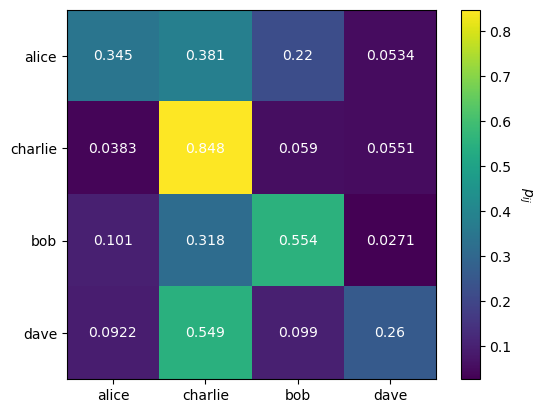

In [263]:
def evaluate_cross_validation(messages_xval, members_msg_xval, members, num_messages_members, prob_message_members, word_dict_train, plot_precc=True):
    """ 

        This function is used to test the performance of the method. We iterate over all messages in the cross validation set.
        It creates a 2D array reppresenting the probability of predicting a member Y given that the message was sent by X.
        Ideally, it should be very high in the diagonal and null (or very small) in the non-diagonal terms



    
    """
    n_members = len(members)

    # Create classifciation matrix
    classification_dict_matrix = {}
    for member in members:        
        classification_dict_matrix[member] = {m: 0 for m in members}

    # We iterate over all messages
    for message_arr_fmt, member in zip(messages_xval, members_msg_xval):
        
        # Convert array to string with spaces
        message = " ".join(message_arr_fmt)
        most_likely_member, _ = naive_bayes_whatsapp_messages(message, members, num_messages_members, prob_message_members, word_dict_train)
        
        classification_dict_matrix[member][most_likely_member] +=1

    # We rescale by the number of messages of member to find the classifciation probabilities
    for member in members: 
        n_msg_member =  sum(classification_dict_matrix[member].values())
        for m  in members: 
            classification_dict_matrix[member][m] /= n_msg_member

    #print(classification_dict_matrix)

    # Accesory ploting funciton
    if plot_precc == True:

        # Converts the dictionary to a numpy array
        n_members = len(members)
        classification_matrix = np.zeros((n_members, n_members))

        for i in range(0,n_members):
            for j in range(0,n_members):
                classification_matrix[i][j] = classification_dict_matrix[members[i]][members[j]]
        
        # Ploting funcitons
        import matplotlib.pyplot as plt

        fig, ax = plt.subplots()
        im = ax.imshow(classification_matrix)

        # Loop over data dimensions and create text annotations.
        for i in range(n_members):
            for j in range(n_members):
                text = ax.text(j, i,  float('%.3g' % classification_matrix[i, j]), ha="center", va="center", color="w")

        # Labels
        ax.set_xticks(np.arange(n_members), labels=members)
        ax.set_yticks(np.arange(n_members), labels=members)

        # 
        cbar = ax.figure.colorbar(im, ax=ax,  cmap="YlGn")
        cbar.ax.set_ylabel(r"$p_{ij}$", rotation=-90, va="bottom")


evaluate_cross_validation(messages_xval, members_msg_xval, members, num_messages_members, prob_message_members, word_dict_train)